Loaded pretrained weights for efficientnet-b0
[Epoch 1/50] Train Loss: 0.6978 | Val Loss: 0.6932 | Val Acc: 51.61%
[Epoch 2/50] Train Loss: 0.6872 | Val Loss: 0.6919 | Val Acc: 50.00%
[Epoch 3/50] Train Loss: 0.6816 | Val Loss: 0.6922 | Val Acc: 46.77%
[Epoch 4/50] Train Loss: 0.6810 | Val Loss: 0.6887 | Val Acc: 46.77%
[Epoch 5/50] Train Loss: 0.6790 | Val Loss: 0.6847 | Val Acc: 61.29%
[Epoch 6/50] Train Loss: 0.6720 | Val Loss: 0.6830 | Val Acc: 62.90%
[Epoch 7/50] Train Loss: 0.6688 | Val Loss: 0.6781 | Val Acc: 62.90%
[Epoch 8/50] Train Loss: 0.6632 | Val Loss: 0.6773 | Val Acc: 66.13%
[Epoch 9/50] Train Loss: 0.6599 | Val Loss: 0.6740 | Val Acc: 59.68%
[Epoch 10/50] Train Loss: 0.6649 | Val Loss: 0.6693 | Val Acc: 66.13%
[Epoch 11/50] Train Loss: 0.6497 | Val Loss: 0.6643 | Val Acc: 74.19%
[Epoch 12/50] Train Loss: 0.6552 | Val Loss: 0.6602 | Val Acc: 77.42%
[Epoch 13/50] Train Loss: 0.6454 | Val Loss: 0.6561 | Val Acc: 70.97%
[Epoch 14/50] Train Loss: 0.6492 | Val Loss: 0.6527 |

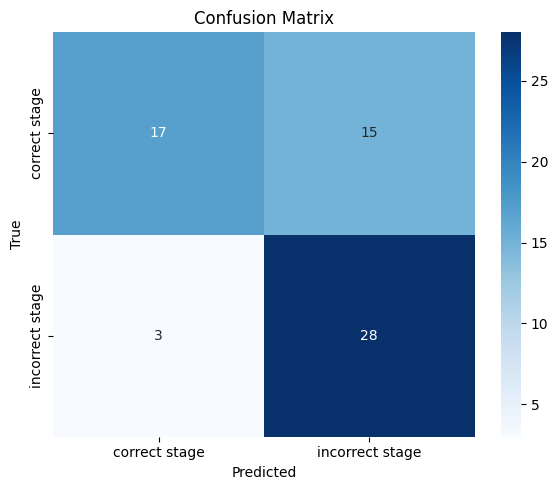


Accuracy for 'correct stage' class: 0.5312
Accuracy for 'incorrect stage' class: 0.9032


In [ ]:
# ------------------------- Imports -------------------------
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
import os

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ------------------------- Transforms -------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale images
])

val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ------------------------- Load Dataset -------------------------
data_dir = "/content/microfluidics-research-individual-embryos/equal_split"

datasets_dict = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)
}

dataloaders = {
    split: DataLoader(datasets_dict[split], batch_size=32, shuffle=(split == 'train'))
    for split in ['train', 'val', 'test']
}

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']
class_names = test_loader.dataset.classes

# ------------------------- Model Setup -------------------------
model = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze entire model initially
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
num_features = model._fc.in_features
model._fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Phase 1: Train Head
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total

    print(f"[Epoch {epoch+1}/50] Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2%}")

# Unfreeze Last Few Layers
for name, param in model.named_parameters():
    if "blocks.6" in name or "conv_head" in name or "_fc" in name:
        param.requires_grad = True  # Unfreeze last block + head

# Reinitialize optimizer with lower LR for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Fine-tuning loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total

    print(f"[Fine-Tune Epoch {epoch+1}/10] Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2%}")

# Final Test Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Per-class accuracy
correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for label, pred in zip(all_labels, all_preds):
    if label == pred:
        correct_per_class[label] += 1
    total_per_class[label] += 1

print()
for i, class_name in enumerate(class_names):
    acc = correct_per_class[i] / total_per_class[i]
    print(f"Accuracy for '{class_name}' class: {acc:.4f}")


Accuracy for 'correct stage' class: 0.6562
Accuracy for 'incorrect stage' class: 0.7097
                 precision    recall  f1-score   support

  correct stage       0.70      0.66      0.68        32
incorrect stage       0.67      0.71      0.69        31

       accuracy                           0.68        63
      macro avg       0.68      0.68      0.68        63
   weighted avg       0.68      0.68      0.68        63



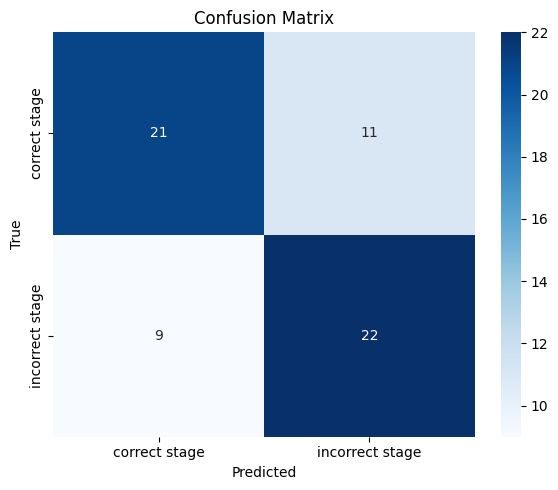

In [ ]:

from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for label, pred in zip(all_labels, all_preds):
    if label == pred:
        correct_per_class[label] += 1
    total_per_class[label] += 1
class_names = test_loader.dataset.classes

for i, class_name in enumerate(class_names):
    acc = correct_per_class[i] / total_per_class[i]
    print(f"Accuracy for '{class_name}' class: {acc:.4f}")


# Classification Report
class_names = test_loader.dataset.classes  # ['Correct', 'Incorrect']
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [5]:
!unzip /content/microfluidics-research-individual-embryos.zip

Archive:  /content/microfluidics-research-individual-embryos.zip
204bcf11f0d219e1b4f734746c3633c0fef31a02
   creating: microfluidics-research-individual-embryos/
 extracting: microfluidics-research-individual-embryos/.gitignore  
  inflating: microfluidics-research-individual-embryos/README.md  
  inflating: microfluidics-research-individual-embryos/clean_files.py  
  inflating: microfluidics-research-individual-embryos/create_split.py  
  inflating: microfluidics-research-individual-embryos/crop_embryos.py  
  inflating: microfluidics-research-individual-embryos/cropped_embryo_labels.csv  
   creating: microfluidics-research-individual-embryos/cropped_embryos/
  inflating: microfluidics-research-individual-embryos/cropped_embryos/1d30-1_jpg.rf.5b3a1c352f9cb7ebd7b75dac67495c93_embryo1071.jpg  
  inflating: microfluidics-research-individual-embryos/cropped_embryos/1d30-1_jpg.rf.5b3a1c352f9cb7ebd7b75dac67495c93_embryo1072.jpg  
  inflating: microfluidics-research-individual-embryos/cropp

In [2]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.1 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=584b8d9284e0c24ed679c41228b11c018a377d1f5842fdf04

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ------------------------- Transforms -------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale
])

val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ------------------------- Load Dataset -------------------------
data_dir = "/content/microfluidics-research-individual-embryos/equal_split"
datasets_dict = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)
}

dataloaders = {
    split: DataLoader(datasets_dict[split], batch_size=32, shuffle=(split == 'train'))
    for split in ['train', 'val', 'test']
}

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']
class_names = test_loader.dataset.classes

# ------------------------- Model Setup -------------------------
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace classifier head
num_features = model._fc.in_features
model._fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------------- Training Loop -------------------------
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2%}")




Loaded pretrained weights for efficientnet-b0
[Epoch 1/20] Train Loss: 0.6926 | Val Loss: 0.6852 | Val Acc: 51.61%
[Epoch 2/20] Train Loss: 0.6733 | Val Loss: 0.6808 | Val Acc: 58.06%
[Epoch 3/20] Train Loss: 0.6584 | Val Loss: 0.6792 | Val Acc: 56.45%
[Epoch 4/20] Train Loss: 0.6209 | Val Loss: 0.6690 | Val Acc: 54.84%
[Epoch 5/20] Train Loss: 0.5709 | Val Loss: 0.6460 | Val Acc: 69.35%
[Epoch 6/20] Train Loss: 0.5241 | Val Loss: 0.6023 | Val Acc: 77.42%
[Epoch 7/20] Train Loss: 0.4982 | Val Loss: 0.5867 | Val Acc: 77.42%
[Epoch 8/20] Train Loss: 0.4523 | Val Loss: 0.5682 | Val Acc: 77.42%
[Epoch 9/20] Train Loss: 0.4050 | Val Loss: 0.5384 | Val Acc: 82.26%
[Epoch 10/20] Train Loss: 0.3897 | Val Loss: 0.4910 | Val Acc: 87.10%
[Epoch 11/20] Train Loss: 0.3940 | Val Loss: 0.4724 | Val Acc: 83.87%
[Epoch 12/20] Train Loss: 0.3540 | Val Loss: 0.4704 | Val Acc: 85.48%
[Epoch 13/20] Train Loss: 0.3560 | Val Loss: 0.4597 | Val Acc: 83.87%
[Epoch 14/20] Train Loss: 0.2878 | Val Loss: 0.4674 |


Final Test Accuracy: 0.7302
                 precision    recall  f1-score   support

  correct stage       0.80      0.62      0.70        32
incorrect stage       0.68      0.84      0.75        31

       accuracy                           0.73        63
      macro avg       0.74      0.73      0.73        63
   weighted avg       0.74      0.73      0.73        63



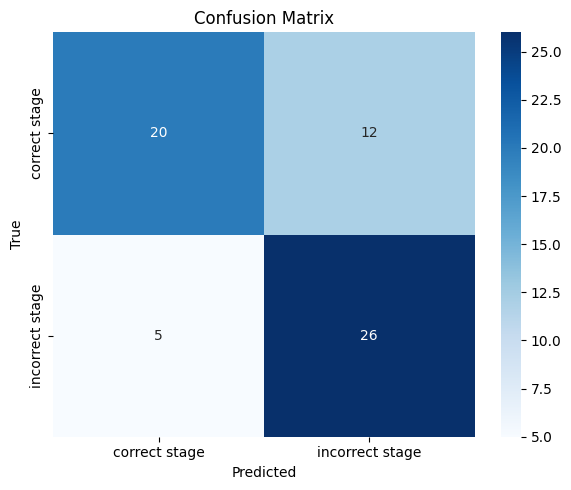


Accuracy for 'correct stage' class: 0.6250
Accuracy for 'incorrect stage' class: 0.8387


In [8]:
# ------------------------- Final Test Evaluation -------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

print(classification_report(all_labels, all_preds, target_names=class_names))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Per-class accuracy
correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)
for label, pred in zip(all_labels, all_preds):
    if label == pred:
        correct_per_class[label] += 1
    total_per_class[label] += 1

print()
for i, class_name in enumerate(class_names):
    acc = correct_per_class[i] / total_per_class[i]
    print(f"Accuracy for '{class_name}' class: {acc:.4f}")